In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from utils import Aircraft
import seaborn as sns
from labellines import labelLines

sns.set_palette('dark')

c:\Users\Elbert\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def digitiserData(data):
    dataX, dataY = zip(*[(float(datapoint.split(', ')[0]), float(datapoint.split(', ')[1])) for datapoint in data.split('; ')])
    return dataX, dataY

# International Standard Atmosphere

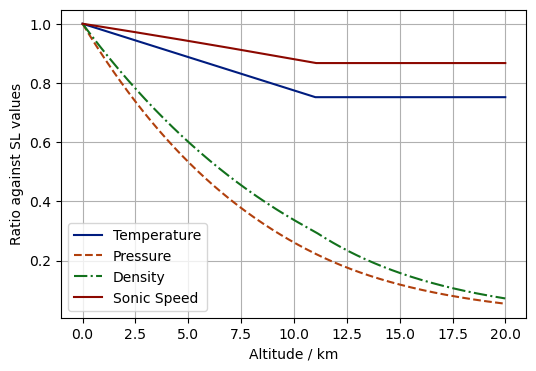

In [3]:
T_sl = 288.15
p_sl = 101325
rho_sl = 1.225
a_sl = 340.3

TRat = []
pRat = []
rhoRat = []
aRat = []

hRange = np.arange(0,20,0.01)

for h in hRange:
    if h <= 11:
        T = T_sl - 6.5*h
        TRat.append(T/T_sl)

        pRat.append((T/T_sl)**5.256)
        rhoRat.append((T/T_sl)**4.256)
        aRat.append((T/T_sl)**0.5)
    elif h <= 20:
        T = 216.65
        TRat.append(T/T_sl)

        tropRat = np.exp(-0.1577*(h-11))
        pRat.append(tropRat*22631/p_sl)
        rhoRat.append(tropRat*0.364/rho_sl)
        aRat.append((T/T_sl)**0.5)


plt.figure(figsize=[6,4])
plt.plot(hRange, TRat, label='Temperature')
plt.plot(hRange, pRat, label='Pressure', linestyle='--')
plt.plot(hRange, rhoRat, label='Density', linestyle='-.')
plt.plot(hRange, aRat, label='Sonic Speed')

plt.xlabel('Altitude / km')
plt.ylabel('Ratio against SL values')
plt.legend()
plt.grid()

plt.show()

# Optimise L/D with Mach number

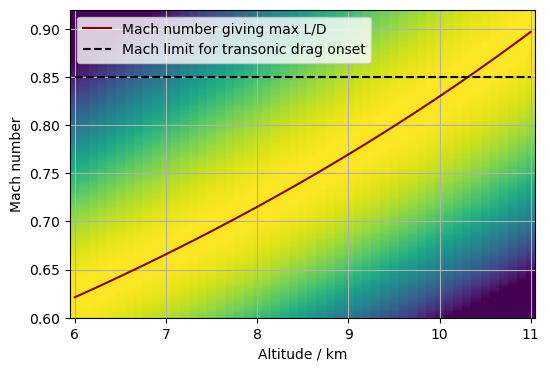

In [4]:
timestep = 10 # s

# Analysis variables
vRat = 1.016 # Ratio of EAS to optimal EAS

W_P = 40_000
W_F = 220_000 - W_P - 106_000

aircraftSpecs = {'W_E':106_000, 'W_MP':40_000, 'W_MTO':220_000, 'W_P':W_P, 'W_F':W_F, # Weight specs
                    'maxPass':240, 'MPRange':12_000, 'W_F_MP':74_000, 'SWing':315, # Other aircraft specs
                    'rEgnine':45, 'thetEngine':6, 'effComp':0.9, 'effTurb':0.9, 'FPREngine':1.45, 'effFan':0.92, 'effTransfer':0.9, 'LCVFuel':42.7e6, # Engine
                    'timestep':timestep, 'k':0.015, 'c1':0.3, 'c2':1.0, 'K1':0.0125, 'K2':0.0446, 'vRat':vRat, 'dontCheckMach':True} # Model parameters

MRange = np.arange(0.6,1,0.001)
hRange = np.arange(6,11.1,0.1)
MLDMax = []
LDMesh = np.zeros((len(hRange), len(MRange)))

for i, h in enumerate(hRange):
    LDs = []

    for j, M in enumerate(MRange):
        aircraft = Aircraft(aircraftSpecs)
        aircraft.updateAllFlightValues(h, MOvrd=M, ft=False)
        LDs.append(1/aircraft.beta)

    LDMesh[i,:] = LDs
    MLDMax.append(aircraft.EASOpt/(aircraft.rho/aircraft.rho_sl)**0.5/aircraft.a)

plt.figure(figsize=[6,4])

MMesh, hMesh = np.meshgrid(MRange, hRange)

plt.pcolormesh(hMesh, MMesh, LDMesh, vmin=np.min(LDMesh)+3)
plt.plot(hRange, MLDMax, color='darkred', label='Mach number giving max L/D')
plt.hlines(0.85, min(hRange), max(hRange), linestyle='--', color='black', label='Mach limit for transonic drag onset')

plt.xlabel('Altitude / km')
plt.ylabel('Mach number')
plt.ylim([0.6, 0.92])
plt.yticks(np.arange(0.6, 0.9, 0.05))
plt.legend(loc='upper left')
plt.grid()
plt.show()


# Fitting to Humidity of Contrail Formation

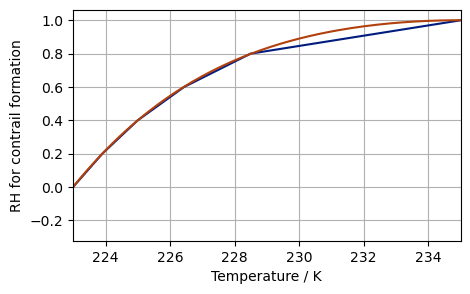

[-2.11945474e-05  1.99228746e-02 -7.02668394e+00  1.10205996e+03
 -6.48519007e+04]


In [5]:
def fitPoly(x,y,order,xFit):
    fitParams = np.polyfit(x, y, order)

    yFit = np.zeros(len(xFit))

    for i in range(order+1):
        yFit += fitParams[i]*xFit**(order-i)

    return yFit, fitParams

RHData = '235, 8.179797542997543; 228.4891891891892, 9.212033415233414; 226.42702702702704, 9.516202457002457; 224.98918918918918, 9.73348796068796; 223.8918918918919, 9.907349385749384; 222.9837837837838, 10.037692383292383'
TRHData,_ = digitiserData(RHData)
RHData = list(np.arange(1,-.1,-0.2))

TRHData = list(reversed(TRHData)) + [235*2-T for T in TRHData]
RHData = list(reversed(RHData)) + RHData

TFit = np.arange(222, 235.1, 0.1)
RHFit, fitParams = fitPoly(TRHData, RHData, 4, TFit)

plt.figure(figsize=[5,3])
plt.plot(TRHData[:6], RHData[:6], label='RH against T from data')
plt.plot(TFit, RHFit, label='Fit line for RH against T')

plt.xlabel('Temperature / K')
plt.ylabel('RH for contrail formation')
plt.xlim([min(TRHData), max(TRHData[:6])])
plt.grid()
plt.show()

print(fitParams)

# Flight

In [6]:
def simulateFlight(aircraftSpecs, altitudes, M=-1):
    aircraft = Aircraft(aircraftSpecs)

    timeData = {'distances':[],
    'times':[],
    'fuelBurns':[],
    'machs':[],
    'Hs':[],
    'LDRats':[],
    'weights':[],
    'effOveralls':[],
    'effCycles':[],
    'effProps':[],
    'W_CO2s':[],
    'W_NOXs':[],
    'W_H2Os':[],
    'cumContrailChances':[],
    'W_H2OContrails':[]}
    
    distance = 0.0
    altIdx = 0

    while aircraft.W_F > 0:
        if distance > altitudes[altIdx+1, 0]:
            # If distance for next stage in altitude sequence has been reached
            altIdx += 1
        alt = altitudes[altIdx, 1]
        
        aircraft.updateAllFlightValues(alt, ft=False, MOvrd=M)

        distance = aircraft.s/1000
        timeData['distances'].append(distance)
        timeData['times'].append(aircraft.time)
        timeData['fuelBurns'].append(aircraft.W_FB/1000)
        timeData['machs'].append(aircraft.M)
        timeData['Hs'].append(aircraft.H/1000)
        timeData['LDRats'].append(1/aircraft.beta)
        timeData['weights'].append(aircraft.W)
        timeData['effOveralls'].append(aircraft.effOverall)
        timeData['effCycles'].append(aircraft.effCycle)
        timeData['effProps'].append(aircraft.effProp)
        timeData['W_CO2s'].append(aircraft.W_CO2)
        timeData['W_NOXs'].append(aircraft.W_NOX)
        timeData['W_H2Os'].append(aircraft.W_H2O)
        timeData['cumContrailChances'].append(aircraft.cumContrailChance)
        timeData['W_H2OContrails'].append(aircraft.W_H2OContrail)

    kgCO2PPKM = timeData['W_CO2s'][-1]/(240*timeData['distances'][-1])
    kgNOxPPKM = timeData['W_NOXs'][-1]/(240*timeData['distances'][-1])
    kgH2OPPKM = timeData['W_H2OContrails'][-1]/(240*timeData['distances'][-1])
    avgContrailChance = timeData['cumContrailChances'][-1]*100/timeData['distances'][-1]
    
    if M!=-1:
        print(f"M = {M:.2f} | Start altitude: {altitudes[0,1]:.2f} | Distance flown: {timeData['distances'][-1]:.0f} km | CO2 pollution: {kgCO2PPKM:.2f} kg/passkm | NOx pollution: {kgNOxPPKM:.2f} kg/passkm | \
H2O contrail pollution: {kgH2OPPKM:.2f} kg/passkm | Avg contrail chance = {avgContrailChance:.2f} % | Time of flight: {timeData['times'][-1]/3600:.2f} hours | Number of iterations: {len(timeData['distances'])}")
    else:
        print(f"v = {aircraftSpecs['vRat']:.3f} | Start altitude: {altitudes[0,1]:.2f} | Distance flown: {timeData['distances'][-1]:.0f} km | CO2 pollution: {kgCO2PPKM:.2f} kg/passkm | NOx pollution: {kgNOxPPKM:.2f} kg/passkm | \
H2O contrail pollution: {kgH2OPPKM:.2f} kg/passkm | Avg contrail chance = {avgContrailChance:.2f} % | Time of flight: {timeData['times'][-1]/3600:.2f} hours | Number of iterations: {len(timeData['distances'])}")

    return timeData

M = 0.60 | Start altitude: 9.50 | Distance flown: 11420 km | CO2 pollution: 83.38 kg/passkm | NOx pollution: 2.31 kg/passkm | H2O contrail pollution: 15.37 kg/passkm | Avg contrail chance = 22.14 % | Time of flight: 17.53 hours | Number of iterations: 6311
M = 0.70 | Start altitude: 9.50 | Distance flown: 12829 km | CO2 pollution: 74.22 kg/passkm | NOx pollution: 2.11 kg/passkm | H2O contrail pollution: 13.68 kg/passkm | Avg contrail chance = 18.98 % | Time of flight: 16.88 hours | Number of iterations: 6077
M = 0.80 | Start altitude: 9.50 | Distance flown: 13094 km | CO2 pollution: 72.72 kg/passkm | NOx pollution: 2.12 kg/passkm | H2O contrail pollution: 13.41 kg/passkm | Avg contrail chance = 16.61 % | Time of flight: 15.07 hours | Number of iterations: 5427
v = 1.000 | Start altitude: 9.50 | Distance flown: 13067 km | CO2 pollution: 72.87 kg/passkm | NOx pollution: 2.09 kg/passkm | H2O contrail pollution: 13.44 kg/passkm | Avg contrail chance = 18.37 % | Time of flight: 16.64 hours 

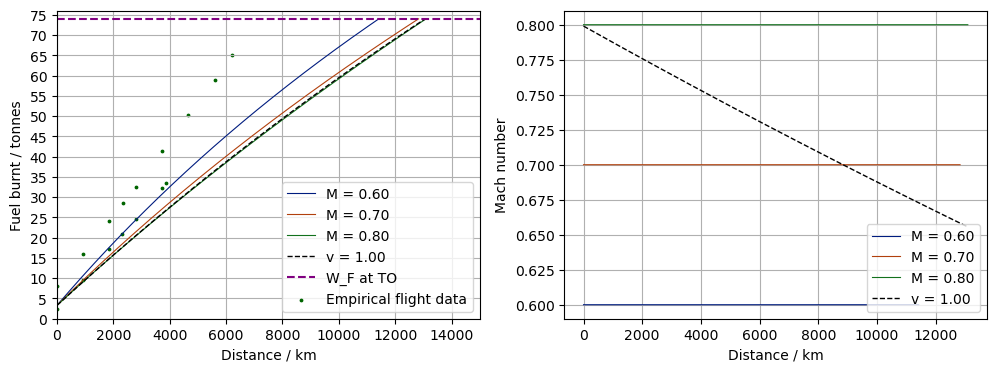

In [7]:
fuelBurnData = '-13.779527559055055, 2508.960573476652; 930.1181102362204, 9677.419354838668; 1860.236220472441, 17275.985663082407; 2321.850393700787, 21003.584229390646; 2790.354330708661, 24587.81362007164; 3727.36220472441, 32329.749103942624; 3861.712598425197, 33548.38709677418; 0, 7956.98924731178; 926.6732283464567, 15985.663082437255; 1853.3464566929133, 24157.706093189918; 2328.740157480315, 28458.78136200717; 2790.354330708661, 32616.4874551971; 3727.36220472441, 41290.32258064514; 4664.370078740157, 50179.21146953403; 5594.488188976376, 58996.415770609296; 6204.232283464566, 65089.605734767'
notesSFB, notesFB = digitiserData(fuelBurnData)
notesFB = np.array(notesFB)/1000

# Analysis variables
timestep = 10 # s
vRat = 1 # Ratio of EAS to optimal EAS

W_P = 40_000
W_F = 220_000 - W_P - 106_000

aircraftSpecs = {'W_E':106_000, 'W_MP':40_000, 'W_MTO':220_000, 'W_P':W_P, 'W_F':W_F, # Weight specs
                    'maxPass':240, 'MPRange':12_000, 'W_F_MP':74_000, 'SWing':315, # Other aircraft specs
                    'rEgnine':45, 'thetEngine':6, 'effComp':0.9, 'effTurb':0.9, 'FPREngine':1.45, 'effFan':0.92, 'effTransfer':0.9, 'LCVFuel':42.7e6, # Engine
                    'timestep':timestep, 'k':0.015, 'c1':0.3, 'c2':1.0, 'K1':0.0125, 'K2':0.0446, 'vRat':vRat, 'dontCheckMach':True} # Model parameters

plt.figure(figsize=[12,4])

altitudes = np.array([[0,9.5],[20000,0]])

MRange = np.arange(0.6,0.86,0.1)

# Plot fuel burn at constant Mach numbers
for M in MRange:
    timeData = simulateFlight(aircraftSpecs, altitudes, M=M)
    plt.subplot(1,2,1)
    plt.plot(timeData['distances'], timeData['fuelBurns'], label=f'M = {M:.2f}', linewidth=0.8)
    plt.subplot(1,2,2)
    plt.plot(timeData['distances'], timeData['machs'], label=f'M = {M:.2f}', linewidth=0.8)

timeData = simulateFlight(aircraftSpecs, altitudes)

# Plot fuel burn with constant vRat as a benchmark
plt.subplot(1,2,1)
plt.plot(timeData['distances'], timeData['fuelBurns'], color='black', label=f'v = {vRat:.2f}', linewidth=1, linestyle='--')

plt.hlines(W_F/1000, 0, 15000, linestyles='--', color='purple', label='W_F at TO')
plt.scatter(notesSFB, notesFB, s=3, color='darkgreen', label='Empirical flight data')

plt.xlabel('Distance / km')
plt.ylabel('Fuel burnt / tonnes')
plt.xlim([0,15000])
plt.ylim([0,76])
plt.yticks(np.arange(0,W_F/1000+5,5))
plt.grid()
plt.legend()

# Plot Mach number over time for the optimised
plt.subplot(1,2,2)
plt.plot(timeData['distances'], timeData['machs'], color='black', label=f'v = {vRat:.2f}', linewidth=1, linestyle='--')

plt.xlabel('Distance / km')
plt.ylabel('Mach number')
plt.grid()
plt.legend()
plt.show()

# Stepped Cruise

In [37]:
def simulateSteppedCruise(aircraftSpecs, startAlt, climbMachThresh, climbAlt):
    aircraft = Aircraft(aircraftSpecs)

    timeData = {'distances':[],
    'altitudes':[],
    'times':[],
    'fuelBurns':[],
    'machs':[],
    'Hs':[],
    'LDRats':[],
    'weights':[],
    'effOveralls':[],
    'effCycles':[],
    'effProps':[],
    'W_CO2s':[],
    'W_NOXs':[],
    'W_H2Os':[],
    'cumContrailChances':[],
    'W_H2OContrails':[]}

    alt = startAlt

    while aircraft.W_F > 0:
        aircraft.updateAllFlightValues(alt, ft=False)

        distance = aircraft.s/1000
        timeData['distances'].append(distance)
        timeData['times'].append(aircraft.time)
        timeData['fuelBurns'].append(aircraft.W_FB/1000)
        timeData['machs'].append(aircraft.M)
        timeData['Hs'].append(aircraft.H/1000)
        timeData['LDRats'].append(1/aircraft.beta)
        timeData['weights'].append(aircraft.W)
        timeData['effOveralls'].append(aircraft.effOverall)
        timeData['effCycles'].append(aircraft.effCycle)
        timeData['effProps'].append(aircraft.effProp)
        timeData['W_CO2s'].append(aircraft.W_CO2)
        timeData['W_NOXs'].append(aircraft.W_NOX)
        timeData['W_H2Os'].append(aircraft.W_H2O)
        timeData['cumContrailChances'].append(aircraft.cumContrailChance)
        timeData['W_H2OContrails'].append(aircraft.W_H2OContrail)

        if timeData['machs'][-1] < climbMachThresh:
            alt += climbAlt

    kgCO2PPKM = timeData['W_CO2s'][-1]/(240*timeData['distances'][-1])
    kgNOxPPKM = timeData['W_NOXs'][-1]/(240*timeData['distances'][-1])
    kgH2OPPKM = timeData['W_H2OContrails'][-1]/(240*timeData['distances'][-1])
    avgContrailChance = timeData['cumContrailChances'][-1]*100/timeData['distances'][-1]
    
    if M!=-1:
        print(f"v = {aircraftSpecs['vRat']:.3f} | Start altitude: {startAlt:.2f} | Distance flown: {timeData['distances'][-1]:.0f} km | CO2 pollution: {kgCO2PPKM:.2f} kg/passkm | NOx pollution: {kgNOxPPKM:.2f} kg/passkm | \
H2O contrail pollution: {kgH2OPPKM:.2f} kg/passkm | Avg contrail chance = {avgContrailChance:.2f} % | Time of flight: {timeData['times'][-1]/3600:.2f} hours | Number of iterations: {len(timeData['distances'])}")
        
    return timeData

v = 1.000 | Start altitude: 10.00 | Distance flown: 13209 km | CO2 pollution: 72.09 kg/passkm | NOx pollution: 2.05 kg/passkm | H2O contrail pollution: 31.84 kg/passkm | Avg contrail chance = 42.67 % | Time of flight: 16.31 hours | Number of iterations: 5871
v = 1.000 | Start altitude: 11.00 | Distance flown: 13486 km | CO2 pollution: 70.61 kg/passkm | NOx pollution: 1.99 kg/passkm | H2O contrail pollution: 32.49 kg/passkm | Avg contrail chance = 41.74 % | Time of flight: 15.64 hours | Number of iterations: 5629
v = 1.000 | Start altitude: 12.00 | Distance flown: 13741 km | CO2 pollution: 69.29 kg/passkm | NOx pollution: 1.99 kg/passkm | H2O contrail pollution: 31.89 kg/passkm | Avg contrail chance = 38.58 % | Time of flight: 14.73 hours | Number of iterations: 5302
Stepped cruise:
v = 1.000 | Start altitude: 10.00 | Distance flown: 13468 km | CO2 pollution: 70.70 kg/passkm | NOx pollution: 2.01 kg/passkm | H2O contrail pollution: 31.99 kg/passkm | Avg contrail chance = 41.19 % | Time 

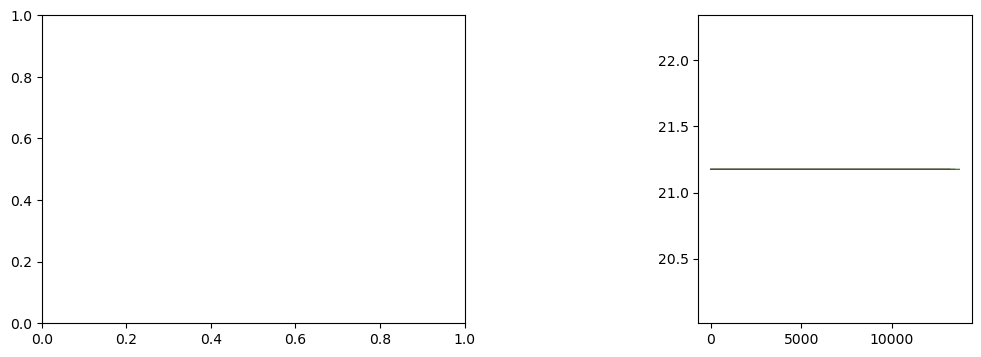

In [49]:
# Plot the Mach number following a speed ratio for different altitudes

timestep = 10 # s
vRat = 1 # Ratio of EAS to optimal EAS

W_P = 40_000
W_F = 220_000 - W_P - 106_000

climbThreshold = 0.775

aircraftSpecs = {'W_E':106_000, 'W_MP':40_000, 'W_MTO':220_000, 'W_P':W_P, 'W_F':W_F, # Weight specs
                    'maxPass':240, 'MPRange':12_000, 'W_F_MP':74_000, 'SWing':315, # Other aircraft specs
                    'rEgnine':45, 'thetEngine':6, 'effComp':0.9, 'effTurb':0.9, 'FPREngine':1.45, 'effFan':0.92, 'effTransfer':0.9, 'LCVFuel':42.7e6, # Engine
                    'timestep':timestep, 'k':0.015, 'c1':0.3, 'c2':1.0, 'K1':0.0125, 'K2':0.0446, 'vRat':vRat, 'dontCheckMach':True} # Model parameters

plt.figure(figsize=[12,4])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

hRange = np.arange(10,12.1,1)

# Plot fuel burn at constant Mach numbers
for h in hRange:
    altitudes = np.array([[0,h],[20000,0]])
    timeData = simulateFlight(aircraftSpecs, altitudes, M=-1)

    ax1.plot(timeData['distances'], timeData['machs'], label=f'h = {h:.1f}', linewidth=0.8)
    ax2.plot(timeData['distances'], timeData['effOveralls'], label=f'h = {h:.1f}', linewidth=0.8)
    ax3.plot(timeData['distances'], timeData['LDRats'], label=f'h = {h:.1f}', linewidth=0.8)

ax1.plot([0,14000],[0.85, 0.85], label='Transonic drag limit', color='black', linestyle='--')

print('Stepped cruise:')
timeData = simulateSteppedCruise(aircraftSpecs, 10, 0.775, 1)
ax1.plot(timeData['distances'], timeData['machs'], linewidth=0.8)
ax2.plot(timeData['distances'], timeData['effOveralls'], linewidth=0.8)

timeData = simulateSteppedCruise(aircraftSpecs, 10, 0.825, 0.3)
ax1.plot(timeData['distances'], timeData['machs'], linewidth=0.8)
ax2.plot(timeData['distances'], timeData['effOveralls'], linewidth=0.8)

ax1.set_xlabel('Distance / km')
ax1.set_ylabel('Mach number')
ax1.grid()

plt.subplot(1,2,1)
xLabels = [6000]*len(hRange) + [10000]
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals=xLabels)

plt.show()

In [ ]:
plt.figure(figsize=[6,4])

timeData = simulateSteppedCruise(aircraftSpecs, 10, 0.8, 1)
plt.plot(timeData['distances'], timeData['machs'], linewidth=0.8)

hRange = np.arange(10,12.1,1)

# Plot fuel burn at constant Mach numbers
for h in hRange:
    altitudes = np.array([[0,h],[20000,0]])
    timeData = simulateFlight(aircraftSpecs, altitudes, M=-1)
    plt.plot(timeData['distances'], timeData['machs'], label=f'h = {h:.1f}', linewidth=0.8)

plt.plot([0,14000],[0.85, 0.85], label='Transonic drag limit', color='black', linestyle='--')
plt.xlabel('Distance / km')
plt.ylabel('Mach number')
plt.grid()

xLabels = [6000]*len(hRange) + [10000]
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals=xLabels)

plt.show()